## Classifiers (Logistic Regression, Random Forest, SVM) for Elastic Scattering PID

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import uproot3 as uproot
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

### Opening the elastic scattering data file

In [2]:
InputFile = uproot.open("InputFile/ElData.root")
InputFile.keys()
InputTree=InputFile["ElTree"]
InputTree.keys()
InputTree.arrays(["BB10En","SX3En","ParticleNum"])
df = InputTree.pandas.df(["BB10En*","SX3En*","ParticleNum*"])
df.head()

,BB10En,SX3En,ParticleNum
entry,,,
0,855.266357,7119.740723,1
1,1123.733643,9418.479492,0
2,997.094299,6100.601074,1
3,867.646790,1102.258423,2
4,867.646790,11893.935547,0


### Preprocessing

In [3]:
df_X = df.iloc[:,:2]
df_Y = np.ravel(df.iloc[:,2:])

#Preprocessing using MinMaxScaler
scaling = MinMaxScaler(feature_range=(-1,1))
df_X[['BB10En','SX3En']] = scaling.fit_transform(df_X[['BB10En','SX3En']])

#Making train and test data
X_train, X_test, y_train, y_test = train_test_split(df_X,df_Y,test_size=0.9)

### 3 Classifier Models

In [4]:
#Logistic Regression 
LRmo = LogisticRegression(solver='lbfgs',multi_class='multinomial')
#Random Forest 
RFmo = RandomForestClassifier(n_estimators=20)
#Support Vector Machine
SVMmo = SVC()

### K-Fold Cross Validation

In [5]:
#Logistic Regression
LRscores = cross_val_score(LogisticRegression(solver='lbfgs',multi_class='multinomial'), df_X, df_Y,cv=3)
print('Accuracy of Logistic Regression: %.3f (%.3f)' % (np.mean(LRscores), np.std(LRscores)))

#Random Forest
RFscores = cross_val_score(RandomForestClassifier(n_estimators=40),df_X, df_Y,cv=3)
print('Accuracy of Random Forest: %.3f (%.3f)' % (np.mean(RFscores), np.std(RFscores)))

#Support Vector Machine
#SVMscores = cross_val_score(SVC(gamma='auto'), df_X, df_Y,cv=3)
#print('Accuracy of SVM: %.3f (%.3f)' % (np.mean(SVMscores), np.std(SVMscores)))
print('Support Vector Machine is too slow to k-fold cross validate because of the large size of the data set')

Accuracy of Logistic Regression: 0.677 (0.005)
Accuracy of Random Forest: 0.999 (0.000)
Support Vector Machine is too slow to k-fold cross validate because of the large size of the data set


### Fitting different models

In [6]:
#Logistic Regression
LRmo.fit(X_train, y_train)
#Random Forest
RFmo.fit(X_train,y_train)
#Support Vector Machine
SVMmo.fit(X_train,y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

### Predictions

In [7]:
#Logistic Regression
predictions_LR = LRmo.predict(X_test)
Y_Predicted_LR = pd.DataFrame(predictions_LR, columns=['Y_Predicted_LR'],index=X_test.index.copy())
#Y_Predicted_LR = pd.DataFrame(predictions_LR, columns=['Y_Predicted_LR'])
df_test = pd.concat([X_test, Y_Predicted_LR], axis =1)

#Random Forest
predictions_RF = RFmo.predict(X_test)
Y_Predicted_RF = pd.DataFrame(predictions_RF, columns=['Y_Predicted_RF'],index=X_test.index.copy())
df_test = pd.concat([df_test, Y_Predicted_RF], axis =1)

#Support Vector Machine
predictions_SVM = SVMmo.predict(X_test)
Y_Predicted_SVM = pd.DataFrame(predictions_SVM, columns=['Y_Predicted_SVM'],index=X_test.index.copy())
df_test = pd.concat([df_test, Y_Predicted_SVM], axis =1)


### Result Visualization

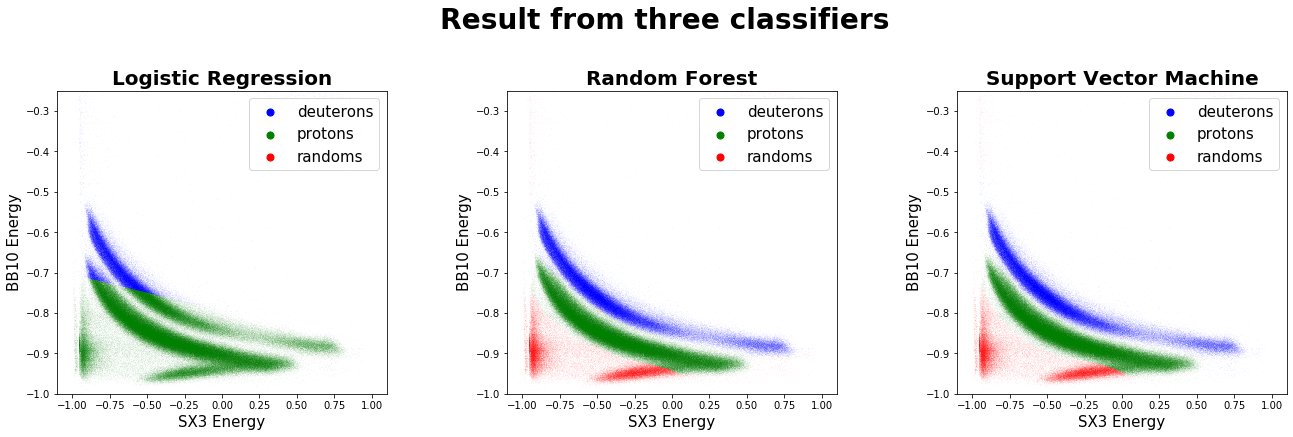

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,7))
fig.tight_layout(pad=9.0)
fig.suptitle('Result from three classifiers', size=28,fontweight="bold")

def Plot(ModelName,ColumnName,AxisName):
    df_test_deuterons = df_test.loc[df_test[ColumnName]==0]
    df_test_protons = df_test.loc[df_test[ColumnName]==1]
    df_test_randoms = df_test.loc[df_test[ColumnName]==2]
    AxisName.scatter(df_test_deuterons['SX3En'], df_test_deuterons['BB10En'],marker='o',s=0.0001,color='blue',label='deuterons')
    AxisName.scatter(df_test_protons['SX3En'], df_test_protons['BB10En'],marker='o',s=0.0001,color='green',label='protons')
    AxisName.scatter(df_test_randoms['SX3En'], df_test_randoms['BB10En'],marker='o',s=0.0001,color='red',label='randoms')
    AxisName.set_title(ModelName, fontsize=20, fontweight="bold")
    AxisName.set(xlabel='SX3 Energy', ylabel='BB10 Energy')
    AxisName.xaxis.get_label().set_fontsize(15)
    AxisName.yaxis.get_label().set_fontsize(15)
    lgnd = AxisName.legend(loc=1,fontsize=15)
    lgnd.legendHandles[0]._sizes = [50]
    lgnd.legendHandles[1]._sizes = [50]
    lgnd.legendHandles[2]._sizes = [50]
    AxisName.set_ylim(-1,-0.25)    

Plot('Logistic Regression','Y_Predicted_LR',ax[0])    
Plot('Random Forest','Y_Predicted_RF',ax[1])    
Plot('Support Vector Machine','Y_Predicted_SVM',ax[2])    

#### Logistic Regression is struggling. Random Forest and SVM are doing really good. For better efficiency with this data set, use Random Forest.